In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
from torch import optim
from sklearn.utils import class_weight
from scipy.stats import *
from torch.autograd import Variable
from tqdm.notebook import tqdm

from save_data import save_data
from sigma import sigma
from get_test_stats import get_test_stats
from size_out import *
from test import test
from train import train
from parameters import *

%load_ext autoreload
%autoreload 2

In [2]:
cyclone_events = np.load('../data/ERA5/ERA5_MSL_1982_2020_3h_0.75/cyclones_events.npz')
closeness_w = np.load('../data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/closeness_w.npy')
degree_w = np.load('../data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/degree_w.npy')
EVC_w = np.load('../data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/EVC_w.npy')
LCC_w = np.load('../data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/LCC_w.npy')
MSLP_preproc = np.load('../data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/input_data/MSLP_preproc.npy')

In [3]:
cyclone_events_2 = cyclone_events[cyclone_events.files[0]]
cyclone_events_4 = cyclone_events[cyclone_events.files[1]]
cyclone_events_6 = cyclone_events[cyclone_events.files[2]]
cyclone_events_8 = cyclone_events[cyclone_events.files[3]]
cyclone_events_10 = cyclone_events[cyclone_events.files[4]]
cyclone_events_12 = cyclone_events[cyclone_events.files[5]]

In [4]:
MSLP_preproc = np.reshape(MSLP_preproc, (36, 69, 113960))
data = MSLP_preproc.copy().astype(np.float32)
data = -np.log(1 - data + 1e-10)

In [5]:
labels = np.zeros(113960)
for i in range(113960):
    if len(cyclone_events_2[:, :, i][cyclone_events_2[:, :, i] != False]) > 0:
        labels[i] = 1

In [6]:
cyclone_occurences = pd.read_csv("../shuffle_cyclone.csv", header=None)
no_cyclone = pd.read_csv("../shuffle_no_cyclone.csv", header=None)

np.nan_to_num(data, nan=0, copy=False)

cyclone_occurences = cyclone_occurences.values[0][:-1]
no_cyclone = no_cyclone.values[0][:-1]

cut_cyclone = int(0.8 * len(cyclone_occurences))
cut_no_cyclone = int(0.8 * len(no_cyclone))

In [7]:
train_id = cyclone_occurences[:cut_cyclone].astype(int)
train_id = np.append(train_id, no_cyclone[:cut_no_cyclone].astype(int))

test_id = cyclone_occurences[cut_cyclone:-1].astype(int) 
test_id = np.append(test_id, no_cyclone[cut_no_cyclone:-1].astype(int))

In [8]:
random.shuffle(train_id)
random.shuffle(test_id)

In [9]:
train_data = torch.tensor(data[:, :, train_id], dtype=torch.double)
test_data = torch.tensor(data[:, :, test_id], dtype=torch.double)

labels_train = torch.tensor(labels[train_id], dtype=torch.int)
labels_test = torch.tensor(labels[test_id], dtype=torch.int)

In [10]:
desc = "First network (10 epochs) with following layers: MaxPooling with kernel=stride=2, \
custom layer applying formula (w*x - a) * b, sigmoid, custom layer applying sum(x) - c. \
Loss - BCELossWithLogits, class weigths applied. Optimizer - Adam with lr=0.0001."
filename = "Cyclone.ipynb"
network_name = filename.split('.')[0]
comment = "Pretty nice."

In [11]:
class MyLayer1(nn.Module):
    
    def __init__(self, w, a, b):
        super().__init__()   
        self.weight = w
        self.a = a
        self.b = b
        
    def forward(self, x):
        # x * w
        x = torch.mul(x, self.weight)
        # x * w - a
        x = torch.sub(x, self.a)
        # (x * w - a) * b
        x = torch.mul(x, self.b)
        return x

class MyLayer2(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.c = c
        
    def forward(self, x):
        x = torch.sum(x, dim=(2, 3))
        x = x.reshape(x.shape[0])
        x = torch.sub(x, self.c)
        return x

class SimpleNN(nn.Module):
    def __init__(self, w, a, b, c):
        super(SimpleNN, self).__init__()
        self.w = nn.Parameter(w, requires_grad=True)  
        self.a = nn.Parameter(a, requires_grad=True)
        self.b = nn.Parameter(b, requires_grad=True)
        self.c = nn.Parameter(c, requires_grad=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = MyLayer1(self.w, self.a, self.b)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = MyLayer2(self.c)
    
    def forward(self, x):
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        return x

$$\sigma(\sum(\sigma((w*x - a) * b)) - c)$$

In [12]:
num_epochs = 30
batch_size = 12

w = torch.empty(size=(), dtype=torch.float)
a = torch.empty(size=(), dtype=torch.float)
b = torch.empty(size=(), dtype=torch.float)
c = torch.empty(size=(), dtype=torch.float)

nn.init.constant_(a, val=1)
nn.init.constant_(b, val=50)
nn.init.constant_(w, val=0.5) # weight init
nn.init.constant_(c, val=2)

cnn = SimpleNN(w, a, b, c)

y = torch.tensor(list(labels_train))
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights=torch.tensor(class_weights, dtype=torch.double)
print(class_weights)
loss_func = nn.BCEWithLogitsLoss(pos_weight=class_weights[1]/class_weights[0], reduction='mean') 
optimizer = optim.Adam(cnn.parameters(), lr = 0.0001)  

tensor([0.5460, 5.9292], dtype=torch.float64)


In [13]:
hyperparameters = (batch_size, w.item(), a.item(), b.item(), c.item())

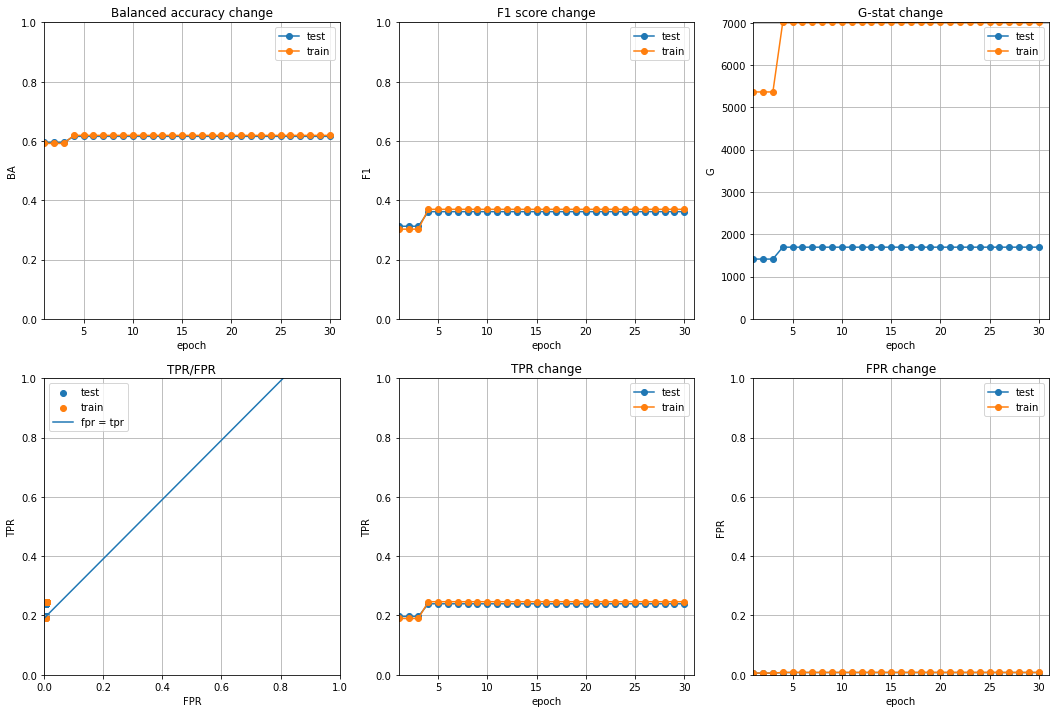

In [14]:
auc_test, auc_train = train(cnn, batch_size, num_epochs, train_data, labels_train, loss_func, optimizer, (test_data, labels_test), draw=False, step_test=True, )

In [15]:
resulting_hyperparameters = [param.data.item() for name, param in cnn.named_parameters()]

In [16]:
tp, tn, fp, fn, sigmas = test(cnn, test_data, labels_test)
test_stats = get_test_stats(test_data.shape[2], tp, tn, fp, fn, sigmas, print_res=False)

In [17]:
tp, tn, fp, fn, sigmas = test(cnn, train_data, labels_train)
train_stats = get_test_stats(train_data.shape[2], tp, tn, fp, fn, sigmas, print_res=False)

In [18]:
trains_stat_vals = list(vars(train_stats).values())
test_stat_vals = list(vars(test_stats).values())

export_stats = [(item_train, item_test) for (item_train, item_test) in zip(trains_stat_vals, test_stat_vals)]
network_params = NetworkParams(network_name, desc, filename, hyperparameters, resulting_hyperparameters, export_stats, auc_train, auc_test, comment)
network_params.save()